Using LSTMs to Predict the Output of Chemical Simulation under Uncertainty

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, LSTMConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

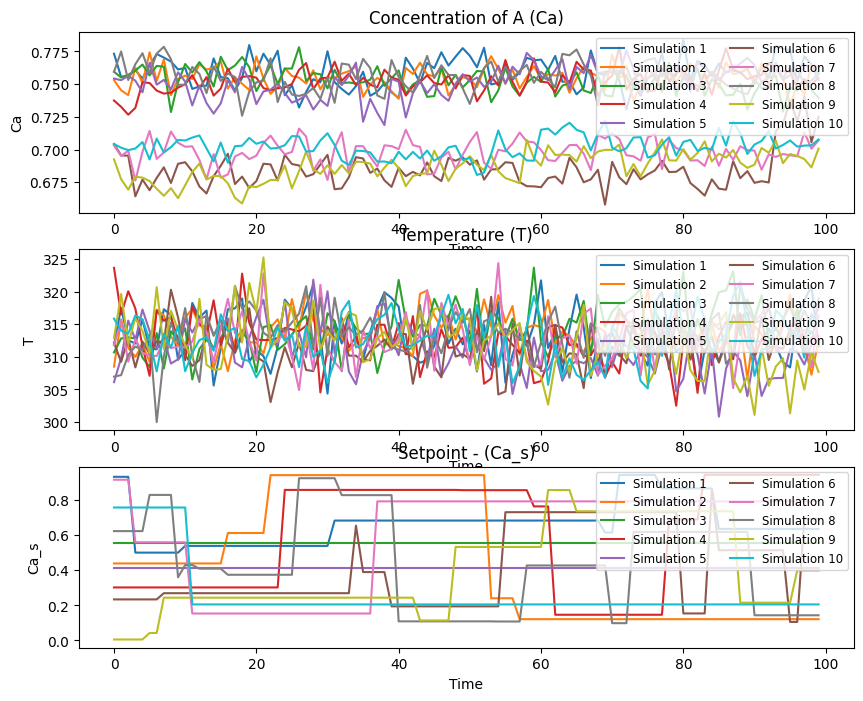

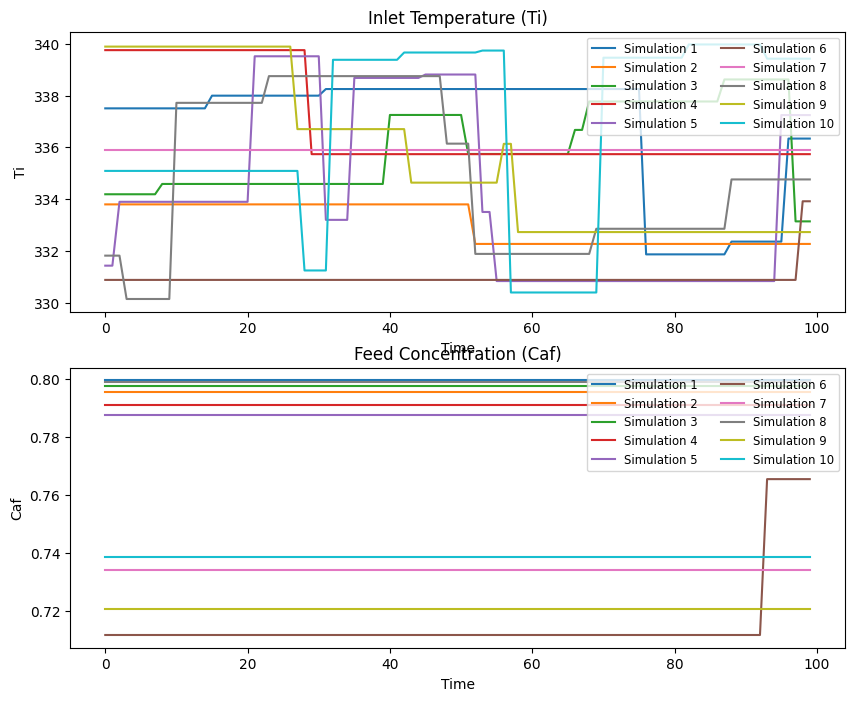

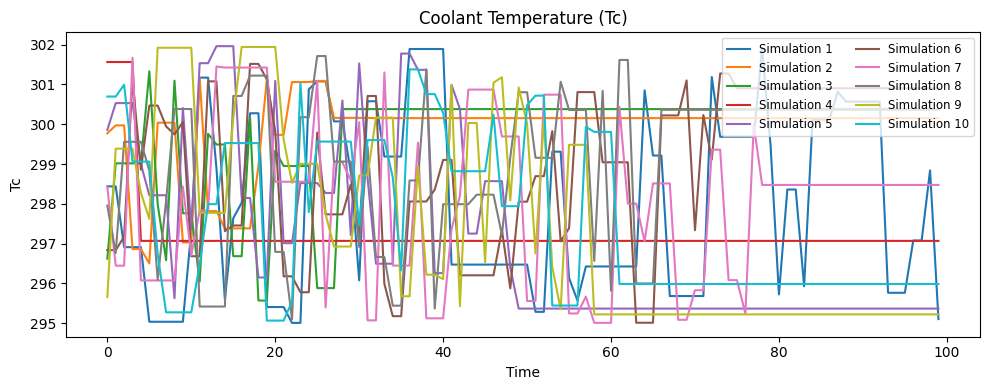

In [13]:
CSTR_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [14]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction LSTM, defining the configuration for the model.

In [ ]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0401, Test Loss: 0.0447, Avg Loss: 0.0424
Epoch [20/50], Train Loss: 0.0400, Test Loss: 0.0458, Avg Loss: 0.0429
Epoch [30/50], Train Loss: 0.0398, Test Loss: 0.0441, Avg Loss: 0.0420
Epoch [40/50], Train Loss: 0.0399, Test Loss: 0.0450, Avg Loss: 0.0425
Epoch [50/50], Train Loss: 0.0398, Test Loss: 0.0450, Avg Loss: 0.0424


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

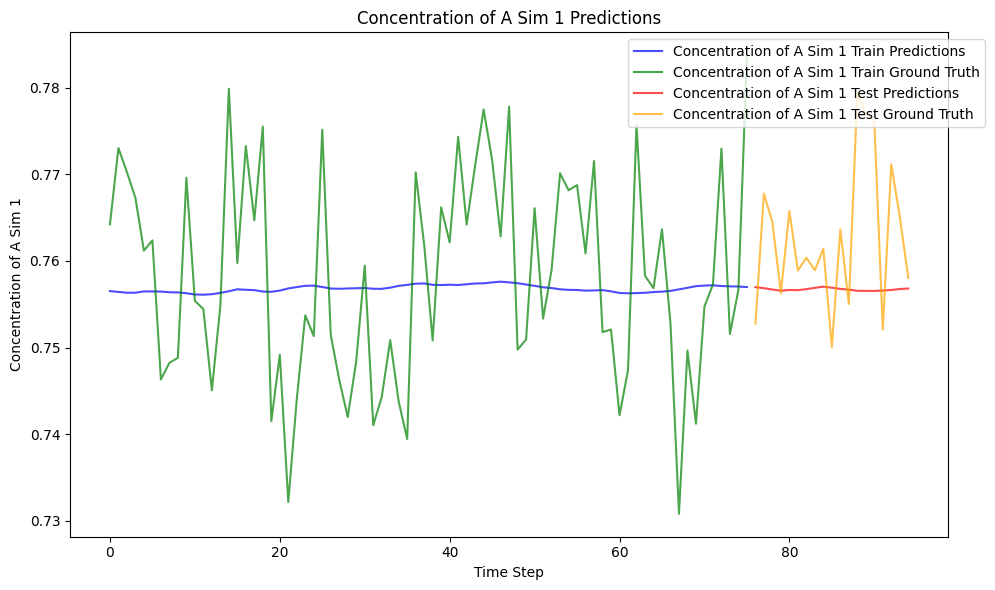

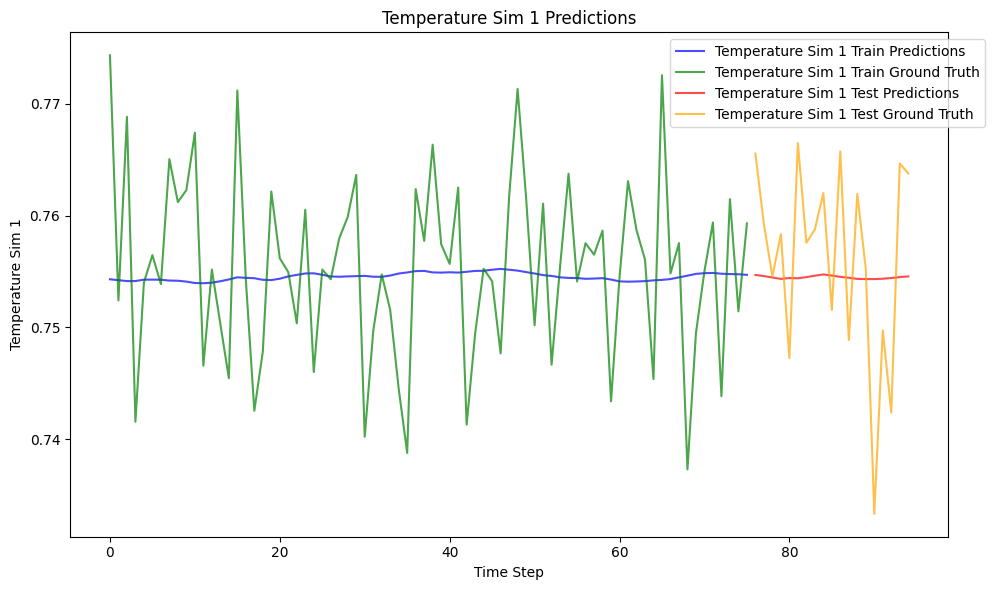

In [16]:
# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)
    

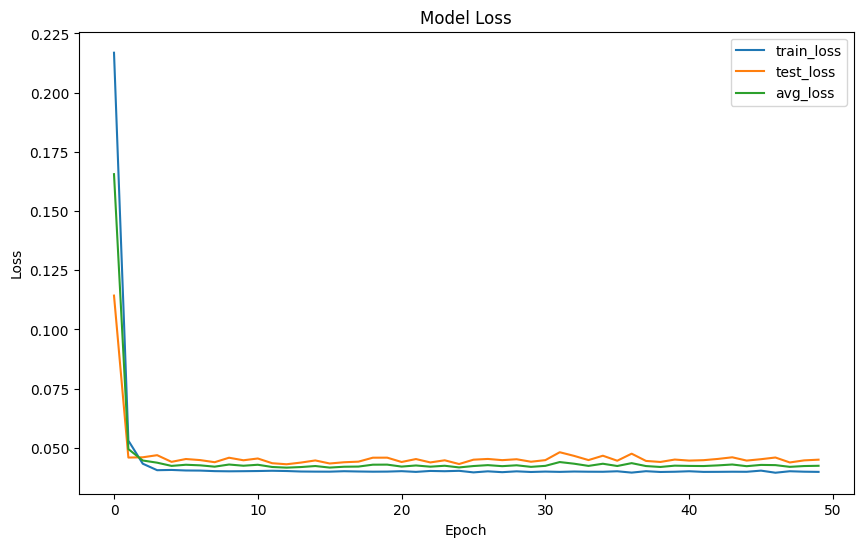

In [17]:
# Plot the loss of the model
visualiser.plot_loss(history)

Can use Bayesian Optimisation to find the best hyperparameters for the model

In [18]:
# First set the bounds for LSTM Model
LSTM_ConfigBounds = {
        'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'num_epochs': (50, 200),
        'learning_rate': (0.0001, 0.1),
        'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
        'horizon': (1, 10),
        'weight_decay': (1e-6, 0.1),
        'factor': (0.1, 0.99),
        'patience': (5, 100),
        'delta': (1e-6, 0.1),   
        
        # LSTM specific bounds
        'hidden_dim': (32, 256),
        'num_layers': (1, 15),
        'dropout': (0.1, 0.9),
        'bidirectional': (0, 1),
        'use_batch_norm': (0, 1),
    
}

# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardLSTM, sim_config=CSTR_Config,
                              train_config=training_config, model_config=LSTM_Config,
                              config_bounds=LSTM_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

best_params, best_loss = optimiser.optimise()
# The best performing model is saved automatically by the optimiser and can be loaded
cp = torch.load('best_model.pth')
model = StandardLSTM(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     )
model.load_state_dict(cp['model_state_dict'])

Epoch [10/194], Train Loss: 0.0530, Test Loss: 0.0510, Avg Loss: 0.0520
Epoch [20/194], Train Loss: 0.0529, Test Loss: 0.0513, Avg Loss: 0.0521
Epoch [30/194], Train Loss: 0.0528, Test Loss: 0.0518, Avg Loss: 0.0523
Epoch [40/194], Train Loss: 0.0520, Test Loss: 0.0512, Avg Loss: 0.0516
Epoch [50/194], Train Loss: 0.0542, Test Loss: 0.0527, Avg Loss: 0.0534
Epoch [60/194], Train Loss: 0.0521, Test Loss: 0.0504, Avg Loss: 0.0512
Epoch [70/194], Train Loss: 0.0534, Test Loss: 0.0507, Avg Loss: 0.0521
Epoch [80/194], Train Loss: 0.0531, Test Loss: 0.0512, Avg Loss: 0.0522
Epoch [90/194], Train Loss: 0.0532, Test Loss: 0.0503, Avg Loss: 0.0518
Epoch [100/194], Train Loss: 0.0558, Test Loss: 0.0527, Avg Loss: 0.0542
Epoch [110/194], Train Loss: 0.0530, Test Loss: 0.0512, Avg Loss: 0.0521
Epoch [120/194], Train Loss: 0.0533, Test Loss: 0.0511, Avg Loss: 0.0522
Epoch [130/194], Train Loss: 0.0538, Test Loss: 0.0522, Avg Loss: 0.0530
Epoch [140/194], Train Loss: 0.0527, Test Loss: 0.0510, Avg 

Optimisation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/183], Train Loss: 0.0593, Test Loss: 0.0554, Avg Loss: 0.0574
Epoch [20/183], Train Loss: 0.0702, Test Loss: 0.0659, Avg Loss: 0.0681
Epoch [30/183], Train Loss: 0.0766, Test Loss: 0.0712, Avg Loss: 0.0739
Epoch [40/183], Train Loss: 0.0826, Test Loss: 0.0765, Avg Loss: 0.0795
Epoch [50/183], Train Loss: 0.0839, Test Loss: 0.0774, Avg Loss: 0.0807
Epoch [60/183], Train Loss: 0.0831, Test Loss: 0.0769, Avg Loss: 0.0800
Epoch [70/183], Train Loss: 0.0833, Test Loss: 0.0770, Avg Loss: 0.0801
Epoch [80/183], Train Loss: 0.0832, Test Loss: 0.0771, Avg Loss: 0.0801
Epoch [90/183], Train Loss: 0.0832, Test Loss: 0.0770, Avg Loss: 0.0801
Epoch [100/183], Train Loss: 0.0833, Test Loss: 0.0771, Avg Loss: 0.0802
Epoch [110/183], Train Loss: 0.0833, Test Loss: 0.0770, Avg Loss: 0.0802
Epoch [120/183], Train Loss: 0.0834, Test Loss: 0.0770, Avg Loss: 0.0802
Epoch [130/183], Train Loss: 0.0830, Test Loss: 0.0770, Avg Loss: 0.0800
Epoch [140/183], Train Loss: 0.0835, Test Loss: 0.0771, Avg 

Optimisation Progress:   5%|▌         | 1/20 [01:18<24:53, 78.63s/it, Loss=0.0537]

Epoch [10/198], Train Loss: 0.0463, Test Loss: 0.0619, Avg Loss: 0.0541
Epoch [20/198], Train Loss: 0.0503, Test Loss: 0.0507, Avg Loss: 0.0505
Epoch [30/198], Train Loss: 0.0505, Test Loss: 0.0515, Avg Loss: 0.0510
Epoch [40/198], Train Loss: 0.0504, Test Loss: 0.0524, Avg Loss: 0.0514
Epoch [50/198], Train Loss: 0.0504, Test Loss: 0.0524, Avg Loss: 0.0514
Epoch [60/198], Train Loss: 0.0517, Test Loss: 0.0524, Avg Loss: 0.0521
Epoch [70/198], Train Loss: 0.0507, Test Loss: 0.0523, Avg Loss: 0.0515
Epoch [80/198], Train Loss: 0.0521, Test Loss: 0.0522, Avg Loss: 0.0522
Epoch [90/198], Train Loss: 0.0512, Test Loss: 0.0523, Avg Loss: 0.0517
Epoch [100/198], Train Loss: 0.0504, Test Loss: 0.0523, Avg Loss: 0.0513
Epoch [110/198], Train Loss: 0.0505, Test Loss: 0.0523, Avg Loss: 0.0514
Epoch [120/198], Train Loss: 0.0505, Test Loss: 0.0523, Avg Loss: 0.0514
Epoch [130/198], Train Loss: 0.0493, Test Loss: 0.0523, Avg Loss: 0.0508
Epoch [140/198], Train Loss: 0.0508, Test Loss: 0.0523, Avg 

Optimisation Progress:  10%|█         | 2/20 [01:26<11:01, 36.75s/it, Loss=0.0518]

Epoch [10/143], Train Loss: 0.0871, Test Loss: 0.0712, Avg Loss: 0.0791
Epoch [20/143], Train Loss: 0.0439, Test Loss: 0.0472, Avg Loss: 0.0456
Epoch [30/143], Train Loss: 0.0412, Test Loss: 0.0585, Avg Loss: 0.0499
Epoch [40/143], Train Loss: 0.0416, Test Loss: 0.0603, Avg Loss: 0.0509
Epoch [50/143], Train Loss: 0.0407, Test Loss: 0.0643, Avg Loss: 0.0525
Epoch [60/143], Train Loss: 0.0408, Test Loss: 0.0601, Avg Loss: 0.0504
Epoch [70/143], Train Loss: 0.0417, Test Loss: 0.0622, Avg Loss: 0.0519
Epoch [80/143], Train Loss: 0.0435, Test Loss: 0.0644, Avg Loss: 0.0539
Epoch [90/143], Train Loss: 0.0416, Test Loss: 0.0608, Avg Loss: 0.0512
Epoch [100/143], Train Loss: 0.0431, Test Loss: 0.0646, Avg Loss: 0.0538
Epoch [110/143], Train Loss: 0.0424, Test Loss: 0.0638, Avg Loss: 0.0531
Epoch [120/143], Train Loss: 0.0421, Test Loss: 0.0628, Avg Loss: 0.0524
Epoch [130/143], Train Loss: 0.0426, Test Loss: 0.0620, Avg Loss: 0.0523
Epoch [140/143], Train Loss: 0.0416, Test Loss: 0.0617, Avg 

Optimisation Progress:  15%|█▌        | 3/20 [03:24<20:58, 74.06s/it, Loss=0.0518]

Epoch [10/52], Train Loss: 84.6272, Test Loss: 1.5500, Avg Loss: 43.0886
Epoch [20/52], Train Loss: 0.2400, Test Loss: 0.1267, Avg Loss: 0.1834
Epoch [30/52], Train Loss: 0.1652, Test Loss: 0.1743, Avg Loss: 0.1697
Epoch [40/52], Train Loss: 0.1143, Test Loss: 0.0622, Avg Loss: 0.0883
Epoch [50/52], Train Loss: 0.0355, Test Loss: 0.0470, Avg Loss: 0.0412


Optimisation Progress:  20%|██        | 4/20 [03:41<13:42, 51.43s/it, Loss=0.0399]

Epoch [10/198], Train Loss: 0.0461, Test Loss: 0.0393, Avg Loss: 0.0427
Epoch [20/198], Train Loss: 0.0428, Test Loss: 0.0395, Avg Loss: 0.0411
Epoch [30/198], Train Loss: 0.0440, Test Loss: 0.0391, Avg Loss: 0.0415
Epoch [40/198], Train Loss: 0.0448, Test Loss: 0.0426, Avg Loss: 0.0437
Epoch [50/198], Train Loss: 0.0470, Test Loss: 0.0386, Avg Loss: 0.0428
Epoch [60/198], Train Loss: 0.0433, Test Loss: 0.0379, Avg Loss: 0.0406
Epoch [70/198], Train Loss: 0.0438, Test Loss: 0.0417, Avg Loss: 0.0427
Epoch [80/198], Train Loss: 0.0436, Test Loss: 0.0407, Avg Loss: 0.0421
Epoch [90/198], Train Loss: 0.0452, Test Loss: 0.0399, Avg Loss: 0.0426
Epoch [100/198], Train Loss: 0.0432, Test Loss: 0.0389, Avg Loss: 0.0410
Epoch [110/198], Train Loss: 0.0435, Test Loss: 0.0387, Avg Loss: 0.0411
Epoch [120/198], Train Loss: 0.0437, Test Loss: 0.0381, Avg Loss: 0.0409
Epoch [130/198], Train Loss: 0.0441, Test Loss: 0.0389, Avg Loss: 0.0415
Epoch [140/198], Train Loss: 0.0469, Test Loss: 0.0381, Avg 

Optimisation Progress:  25%|██▌       | 5/20 [04:30<12:39, 50.66s/it, Loss=0.0399]

Epoch [10/200], Train Loss: 0.0822, Test Loss: 0.0865, Avg Loss: 0.0843
Epoch [20/200], Train Loss: 0.0885, Test Loss: 0.0940, Avg Loss: 0.0912
Epoch [30/200], Train Loss: 0.0871, Test Loss: 0.0921, Avg Loss: 0.0896
Epoch [40/200], Train Loss: 0.0880, Test Loss: 0.0923, Avg Loss: 0.0901
Epoch [50/200], Train Loss: 0.0880, Test Loss: 0.0926, Avg Loss: 0.0903
Epoch [60/200], Train Loss: 0.0870, Test Loss: 0.0925, Avg Loss: 0.0897
Epoch [70/200], Train Loss: 0.0879, Test Loss: 0.0925, Avg Loss: 0.0902
Epoch [80/200], Train Loss: 0.0860, Test Loss: 0.0926, Avg Loss: 0.0893
Epoch [90/200], Train Loss: 0.0874, Test Loss: 0.0927, Avg Loss: 0.0900
Epoch [100/200], Train Loss: 0.0862, Test Loss: 0.0927, Avg Loss: 0.0894
Epoch [110/200], Train Loss: 0.0877, Test Loss: 0.0927, Avg Loss: 0.0902
Epoch [120/200], Train Loss: 0.0849, Test Loss: 0.0927, Avg Loss: 0.0888
Epoch [130/200], Train Loss: 0.0873, Test Loss: 0.0927, Avg Loss: 0.0900
Epoch [140/200], Train Loss: 0.0857, Test Loss: 0.0927, Avg 

Optimisation Progress:  30%|███       | 6/20 [04:35<08:12, 35.16s/it, Loss=0.0399]

Epoch [10/138], Train Loss: 0.9576, Test Loss: 1.7726, Avg Loss: 1.3651
Epoch [20/138], Train Loss: 0.2611, Test Loss: 0.0464, Avg Loss: 0.1537
Epoch [30/138], Train Loss: 0.0497, Test Loss: 0.0522, Avg Loss: 0.0509
Epoch [40/138], Train Loss: 0.0437, Test Loss: 0.0487, Avg Loss: 0.0462
Epoch [50/138], Train Loss: 0.0438, Test Loss: 0.0484, Avg Loss: 0.0461
Epoch [60/138], Train Loss: 0.0437, Test Loss: 0.0497, Avg Loss: 0.0467
Epoch [70/138], Train Loss: 0.0430, Test Loss: 0.0502, Avg Loss: 0.0466
Epoch [80/138], Train Loss: 0.0428, Test Loss: 0.0476, Avg Loss: 0.0452
Epoch [90/138], Train Loss: 0.0444, Test Loss: 0.0511, Avg Loss: 0.0477
Epoch [100/138], Train Loss: 0.0449, Test Loss: 0.0504, Avg Loss: 0.0477
Epoch [110/138], Train Loss: 0.0421, Test Loss: 0.0484, Avg Loss: 0.0452
Epoch [120/138], Train Loss: 0.0415, Test Loss: 0.0495, Avg Loss: 0.0455
Epoch [130/138], Train Loss: 0.0454, Test Loss: 0.0485, Avg Loss: 0.0469


Optimisation Progress:  35%|███▌      | 7/20 [05:10<07:35, 35.05s/it, Loss=0.0399]

Epoch [10/121], Train Loss: 0.0909, Test Loss: 0.0892, Avg Loss: 0.0900
Epoch [20/121], Train Loss: 0.0907, Test Loss: 0.0894, Avg Loss: 0.0901
Epoch [30/121], Train Loss: 0.0901, Test Loss: 0.0927, Avg Loss: 0.0914
Epoch [40/121], Train Loss: 0.0909, Test Loss: 0.0896, Avg Loss: 0.0902
Epoch [50/121], Train Loss: 0.0910, Test Loss: 0.0949, Avg Loss: 0.0929
Epoch [60/121], Train Loss: 0.0915, Test Loss: 0.0854, Avg Loss: 0.0885
Epoch [70/121], Train Loss: 0.0900, Test Loss: 0.0911, Avg Loss: 0.0906
Epoch [80/121], Train Loss: 0.0904, Test Loss: 0.0868, Avg Loss: 0.0886
Epoch [90/121], Train Loss: 0.0901, Test Loss: 0.0898, Avg Loss: 0.0900
Epoch [100/121], Train Loss: 0.0881, Test Loss: 0.0894, Avg Loss: 0.0887
Epoch [110/121], Train Loss: 0.0907, Test Loss: 0.0891, Avg Loss: 0.0899


Optimisation Progress:  40%|████      | 8/20 [05:17<05:12, 26.03s/it, Loss=0.0399]

Epoch [120/121], Train Loss: 0.0877, Test Loss: 0.0896, Avg Loss: 0.0886
Epoch [10/107], Train Loss: 5.4921, Test Loss: 3.4161, Avg Loss: 4.4541
Epoch [20/107], Train Loss: 1.8639, Test Loss: 0.0868, Avg Loss: 0.9753
Epoch [30/107], Train Loss: 0.0729, Test Loss: 0.0732, Avg Loss: 0.0731
Epoch [40/107], Train Loss: 0.0521, Test Loss: 0.0655, Avg Loss: 0.0588
Epoch [50/107], Train Loss: 0.0546, Test Loss: 0.0553, Avg Loss: 0.0550
Epoch [60/107], Train Loss: 0.0556, Test Loss: 0.0559, Avg Loss: 0.0558
Epoch [70/107], Train Loss: 0.0587, Test Loss: 0.0592, Avg Loss: 0.0590
Epoch [80/107], Train Loss: 0.0623, Test Loss: 0.0620, Avg Loss: 0.0622
Epoch [90/107], Train Loss: 0.0632, Test Loss: 0.0630, Avg Loss: 0.0631
Epoch [100/107], Train Loss: 0.0646, Test Loss: 0.0642, Avg Loss: 0.0644


Optimisation Progress:  45%|████▌     | 9/20 [05:34<04:16, 23.31s/it, Loss=0.0399]

Epoch [10/62], Train Loss: 0.0515, Test Loss: 0.0556, Avg Loss: 0.0535
Epoch [20/62], Train Loss: 0.0517, Test Loss: 0.0556, Avg Loss: 0.0537
Epoch [30/62], Train Loss: 0.0502, Test Loss: 0.0572, Avg Loss: 0.0537
Epoch [40/62], Train Loss: 0.0528, Test Loss: 0.0549, Avg Loss: 0.0539
Epoch [50/62], Train Loss: 0.0516, Test Loss: 0.0560, Avg Loss: 0.0538
Epoch [60/62], Train Loss: 0.0518, Test Loss: 0.0580, Avg Loss: 0.0549


Optimisation Progress:  50%|█████     | 10/20 [06:05<04:17, 25.77s/it, Loss=0.0399]

Epoch [10/144], Train Loss: 0.0967, Test Loss: 0.0866, Avg Loss: 0.0916
Epoch [20/144], Train Loss: 0.1062, Test Loss: 0.1121, Avg Loss: 0.1091
Epoch [30/144], Train Loss: 0.1027, Test Loss: 0.1337, Avg Loss: 0.1182
Epoch [40/144], Train Loss: 0.1222, Test Loss: 0.1037, Avg Loss: 0.1129
Epoch [50/144], Train Loss: 0.1320, Test Loss: 0.1254, Avg Loss: 0.1287
Epoch [60/144], Train Loss: 0.1079, Test Loss: 0.0945, Avg Loss: 0.1012
Epoch [70/144], Train Loss: 0.2001, Test Loss: 0.2418, Avg Loss: 0.2209
Epoch [80/144], Train Loss: 0.1845, Test Loss: 0.2378, Avg Loss: 0.2112
Epoch [90/144], Train Loss: 0.0980, Test Loss: 0.0996, Avg Loss: 0.0988
Epoch [100/144], Train Loss: 0.1065, Test Loss: 0.0910, Avg Loss: 0.0987
Epoch [110/144], Train Loss: 0.1827, Test Loss: 0.1710, Avg Loss: 0.1769
Epoch [120/144], Train Loss: 0.1185, Test Loss: 0.1386, Avg Loss: 0.1285
Epoch [130/144], Train Loss: 0.1190, Test Loss: 0.1051, Avg Loss: 0.1121
Epoch [140/144], Train Loss: 0.1220, Test Loss: 0.2046, Avg 

Optimisation Progress:  55%|█████▌    | 11/20 [08:07<08:17, 55.24s/it, Loss=0.0399]

Epoch [10/189], Train Loss: 0.0420, Test Loss: 0.0353, Avg Loss: 0.0386
Epoch [20/189], Train Loss: 0.0417, Test Loss: 0.0407, Avg Loss: 0.0412
Epoch [30/189], Train Loss: 0.0409, Test Loss: 0.0368, Avg Loss: 0.0388
Epoch [40/189], Train Loss: 0.0424, Test Loss: 0.0373, Avg Loss: 0.0399
Epoch [50/189], Train Loss: 0.0421, Test Loss: 0.0385, Avg Loss: 0.0403
Epoch [60/189], Train Loss: 0.0415, Test Loss: 0.0387, Avg Loss: 0.0401
Epoch [70/189], Train Loss: 0.0418, Test Loss: 0.0379, Avg Loss: 0.0399
Epoch [80/189], Train Loss: 0.0419, Test Loss: 0.0386, Avg Loss: 0.0402
Epoch [90/189], Train Loss: 0.0414, Test Loss: 0.0385, Avg Loss: 0.0399
Epoch [100/189], Train Loss: 0.0419, Test Loss: 0.0383, Avg Loss: 0.0401
Epoch [110/189], Train Loss: 0.0419, Test Loss: 0.0386, Avg Loss: 0.0402
Epoch [120/189], Train Loss: 0.0418, Test Loss: 0.0380, Avg Loss: 0.0399
Epoch [130/189], Train Loss: 0.0413, Test Loss: 0.0386, Avg Loss: 0.0399
Epoch [140/189], Train Loss: 0.0412, Test Loss: 0.0374, Avg 

Optimisation Progress:  60%|██████    | 12/20 [08:30<06:01, 45.20s/it, Loss=0.0397]

Epoch [160/189], Train Loss: 0.0414, Test Loss: 0.0379, Avg Loss: 0.0397
Early Stopping
Epoch [10/131], Train Loss: 6.4399, Test Loss: 3.0052, Avg Loss: 4.7226
Epoch [20/131], Train Loss: 0.2592, Test Loss: 3.3551, Avg Loss: 1.8072
Epoch [30/131], Train Loss: 0.1890, Test Loss: 1.6965, Avg Loss: 0.9427
Epoch [40/131], Train Loss: 0.1497, Test Loss: 0.3385, Avg Loss: 0.2441
Epoch [50/131], Train Loss: 0.0378, Test Loss: 0.0462, Avg Loss: 0.0420
Epoch [60/131], Train Loss: 0.0409, Test Loss: 0.0432, Avg Loss: 0.0420
Epoch [70/131], Train Loss: 0.0402, Test Loss: 0.0483, Avg Loss: 0.0442
Epoch [80/131], Train Loss: 0.0430, Test Loss: 0.0496, Avg Loss: 0.0463
Epoch [90/131], Train Loss: 0.0430, Test Loss: 0.0494, Avg Loss: 0.0462
Epoch [100/131], Train Loss: 0.0431, Test Loss: 0.0497, Avg Loss: 0.0464
Epoch [110/131], Train Loss: 0.0434, Test Loss: 0.0502, Avg Loss: 0.0468
Epoch [120/131], Train Loss: 0.0438, Test Loss: 0.0505, Avg Loss: 0.0471
Epoch [130/131], Train Loss: 0.0440, Test Los

Optimisation Progress:  65%|██████▌   | 13/20 [09:01<04:47, 41.03s/it, Loss=0.0397]

Epoch [10/189], Train Loss: 0.1119, Test Loss: 0.0985, Avg Loss: 0.1052
Epoch [20/189], Train Loss: 0.0505, Test Loss: 0.0401, Avg Loss: 0.0453
Epoch [30/189], Train Loss: 0.0507, Test Loss: 0.0386, Avg Loss: 0.0446
Epoch [40/189], Train Loss: 0.0557, Test Loss: 0.0460, Avg Loss: 0.0509
Epoch [50/189], Train Loss: 0.0588, Test Loss: 0.0466, Avg Loss: 0.0527
Epoch [60/189], Train Loss: 0.0389, Test Loss: 0.0381, Avg Loss: 0.0385
Epoch [70/189], Train Loss: 0.0555, Test Loss: 0.0390, Avg Loss: 0.0472
Epoch [80/189], Train Loss: 0.0439, Test Loss: 0.0421, Avg Loss: 0.0430
Epoch [90/189], Train Loss: 0.0465, Test Loss: 0.0359, Avg Loss: 0.0412
Epoch [100/189], Train Loss: 0.0448, Test Loss: 0.0407, Avg Loss: 0.0428
Epoch [110/189], Train Loss: 0.0440, Test Loss: 0.0468, Avg Loss: 0.0454
Epoch [120/189], Train Loss: 0.0605, Test Loss: 0.0380, Avg Loss: 0.0492
Epoch [130/189], Train Loss: 0.0432, Test Loss: 0.0452, Avg Loss: 0.0442
Epoch [140/189], Train Loss: 0.0397, Test Loss: 0.0431, Avg 

Optimisation Progress:  70%|███████   | 14/20 [09:09<03:05, 30.96s/it, Loss=0.0397]

Epoch [10/170], Train Loss: 0.0730, Test Loss: 0.0699, Avg Loss: 0.0715
Epoch [20/170], Train Loss: 0.0924, Test Loss: 0.0848, Avg Loss: 0.0886
Epoch [30/170], Train Loss: 0.0884, Test Loss: 0.0828, Avg Loss: 0.0856
Epoch [40/170], Train Loss: 0.0911, Test Loss: 0.0827, Avg Loss: 0.0869
Epoch [50/170], Train Loss: 0.0931, Test Loss: 0.0837, Avg Loss: 0.0884
Epoch [60/170], Train Loss: 0.0916, Test Loss: 0.0833, Avg Loss: 0.0875
Epoch [70/170], Train Loss: 0.0942, Test Loss: 0.0834, Avg Loss: 0.0888


Optimisation Progress:  75%|███████▌  | 15/20 [09:19<02:03, 24.77s/it, Loss=0.0397]

Epoch [80/170], Train Loss: 0.0919, Test Loss: 0.0835, Avg Loss: 0.0877
Early Stopping
Epoch [10/79], Train Loss: 0.0885, Test Loss: 0.1118, Avg Loss: 0.1002
Epoch [20/79], Train Loss: 0.0894, Test Loss: 0.1125, Avg Loss: 0.1009
Epoch [30/79], Train Loss: 0.0874, Test Loss: 0.1134, Avg Loss: 0.1004
Epoch [40/79], Train Loss: 0.0896, Test Loss: 0.1106, Avg Loss: 0.1001
Epoch [50/79], Train Loss: 0.0927, Test Loss: 0.1164, Avg Loss: 0.1045
Epoch [60/79], Train Loss: 0.0885, Test Loss: 0.1131, Avg Loss: 0.1008
Epoch [70/79], Train Loss: 0.0969, Test Loss: 0.1131, Avg Loss: 0.1050


Optimisation Progress:  80%|████████  | 16/20 [09:55<01:52, 28.19s/it, Loss=0.0397]

Epoch [10/160], Train Loss: 0.0761, Test Loss: 0.0770, Avg Loss: 0.0766
Epoch [20/160], Train Loss: 0.0753, Test Loss: 0.0807, Avg Loss: 0.0780
Epoch [30/160], Train Loss: 0.0758, Test Loss: 0.0794, Avg Loss: 0.0776
Epoch [40/160], Train Loss: 0.0758, Test Loss: 0.0774, Avg Loss: 0.0766
Epoch [50/160], Train Loss: 0.0768, Test Loss: 0.0798, Avg Loss: 0.0783
Epoch [60/160], Train Loss: 0.0756, Test Loss: 0.0805, Avg Loss: 0.0780
Epoch [70/160], Train Loss: 0.0762, Test Loss: 0.0791, Avg Loss: 0.0776
Epoch [80/160], Train Loss: 0.0757, Test Loss: 0.0799, Avg Loss: 0.0778
Epoch [90/160], Train Loss: 0.0757, Test Loss: 0.0775, Avg Loss: 0.0766
Epoch [100/160], Train Loss: 0.0755, Test Loss: 0.0798, Avg Loss: 0.0776
Epoch [110/160], Train Loss: 0.0752, Test Loss: 0.0794, Avg Loss: 0.0773
Epoch [120/160], Train Loss: 0.0752, Test Loss: 0.0778, Avg Loss: 0.0765
Epoch [130/160], Train Loss: 0.0754, Test Loss: 0.0791, Avg Loss: 0.0772
Epoch [140/160], Train Loss: 0.0755, Test Loss: 0.0793, Avg 

Optimisation Progress:  85%|████████▌ | 17/20 [11:53<02:44, 54.98s/it, Loss=0.0397]

Epoch [160/160], Train Loss: 0.0755, Test Loss: 0.0800, Avg Loss: 0.0778
Epoch [10/98], Train Loss: 0.0663, Test Loss: 0.0775, Avg Loss: 0.0719
Epoch [20/98], Train Loss: 0.0765, Test Loss: 0.0917, Avg Loss: 0.0841
Epoch [30/98], Train Loss: 0.0772, Test Loss: 0.0927, Avg Loss: 0.0849
Epoch [40/98], Train Loss: 0.0761, Test Loss: 0.0922, Avg Loss: 0.0841
Epoch [50/98], Train Loss: 0.0751, Test Loss: 0.0921, Avg Loss: 0.0836
Epoch [60/98], Train Loss: 0.0756, Test Loss: 0.0924, Avg Loss: 0.0840
Epoch [70/98], Train Loss: 0.0741, Test Loss: 0.0916, Avg Loss: 0.0829
Epoch [80/98], Train Loss: 0.0757, Test Loss: 0.0922, Avg Loss: 0.0840
Epoch [90/98], Train Loss: 0.0766, Test Loss: 0.0922, Avg Loss: 0.0844


Optimisation Progress:  90%|█████████ | 18/20 [13:28<02:13, 66.99s/it, Loss=0.0397]

Epoch [10/54], Train Loss: 0.2600, Test Loss: 0.4259, Avg Loss: 0.3430
Epoch [20/54], Train Loss: 0.1337, Test Loss: 0.1195, Avg Loss: 0.1266
Epoch [30/54], Train Loss: 0.0566, Test Loss: 0.0773, Avg Loss: 0.0669
Epoch [40/54], Train Loss: 0.0502, Test Loss: 0.0655, Avg Loss: 0.0578
Epoch [50/54], Train Loss: 0.0446, Test Loss: 0.0566, Avg Loss: 0.0506


Optimisation Progress:  95%|█████████▌| 19/20 [13:41<00:50, 50.98s/it, Loss=0.0397]

Epoch [10/87], Train Loss: 30.4332, Test Loss: 31.9822, Avg Loss: 31.2077
Epoch [20/87], Train Loss: 0.0675, Test Loss: 0.1427, Avg Loss: 0.1051
Epoch [30/87], Train Loss: 0.4589, Test Loss: 41.0426, Avg Loss: 20.7508
Epoch [40/87], Train Loss: 2.5821, Test Loss: 17.4454, Avg Loss: 10.0138
Epoch [50/87], Train Loss: 2.2731, Test Loss: 0.4750, Avg Loss: 1.3741
Epoch [60/87], Train Loss: 0.0480, Test Loss: 0.0679, Avg Loss: 0.0579
Epoch [70/87], Train Loss: 0.0375, Test Loss: 0.0555, Avg Loss: 0.0465
Epoch [80/87], Train Loss: 0.0397, Test Loss: 0.0562, Avg Loss: 0.0480


Optimisation Progress: 100%|██████████| 20/20 [14:10<00:00, 42.54s/it, Loss=0.0397]


<All keys matched successfully>

After optimising the model, load the data

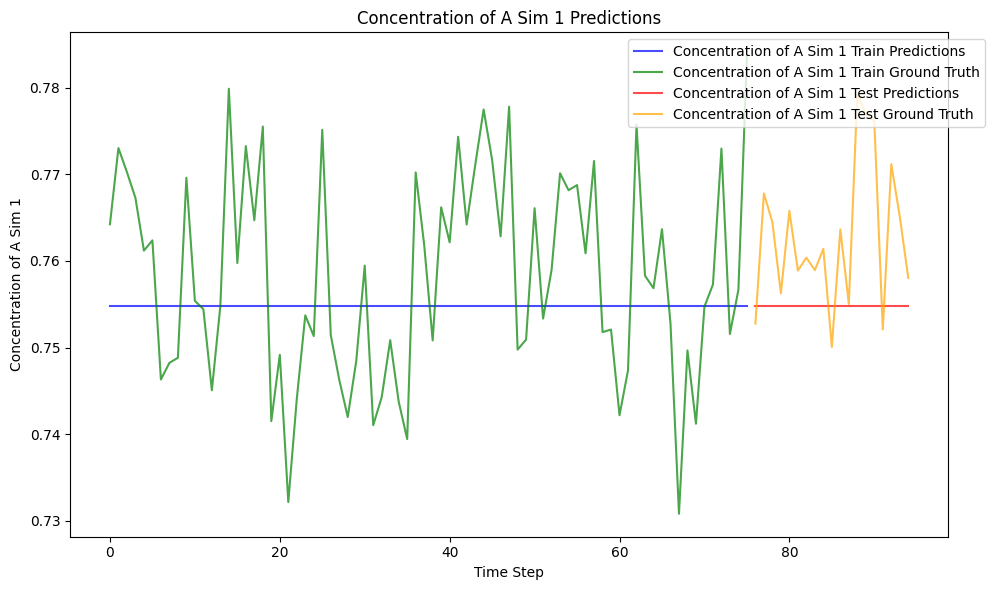

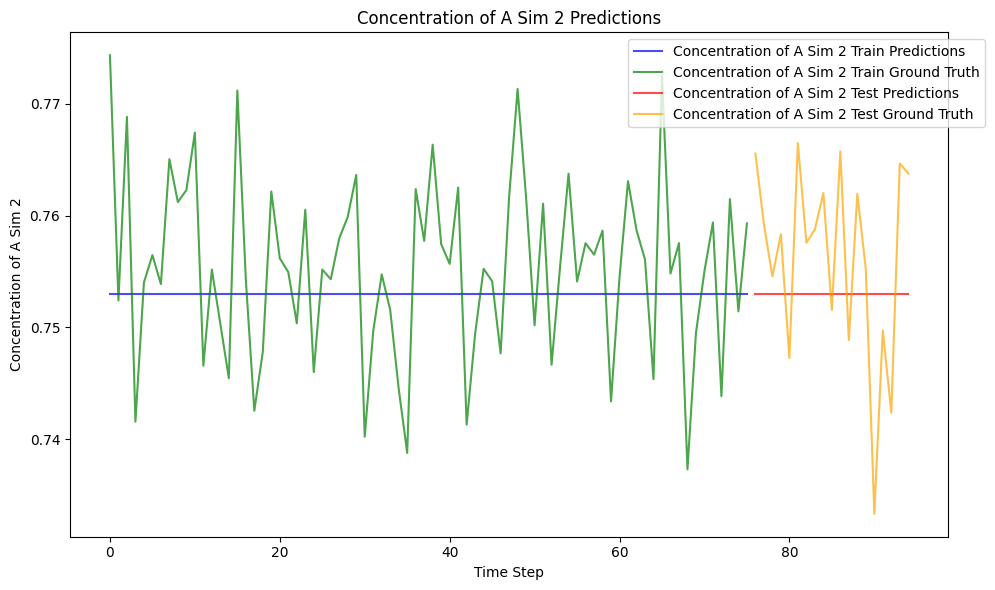

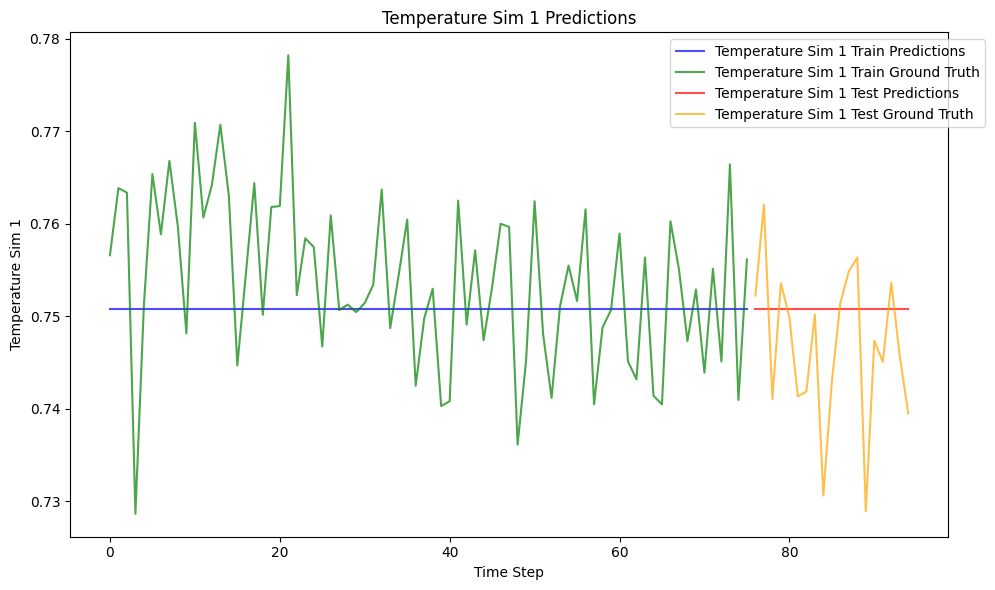

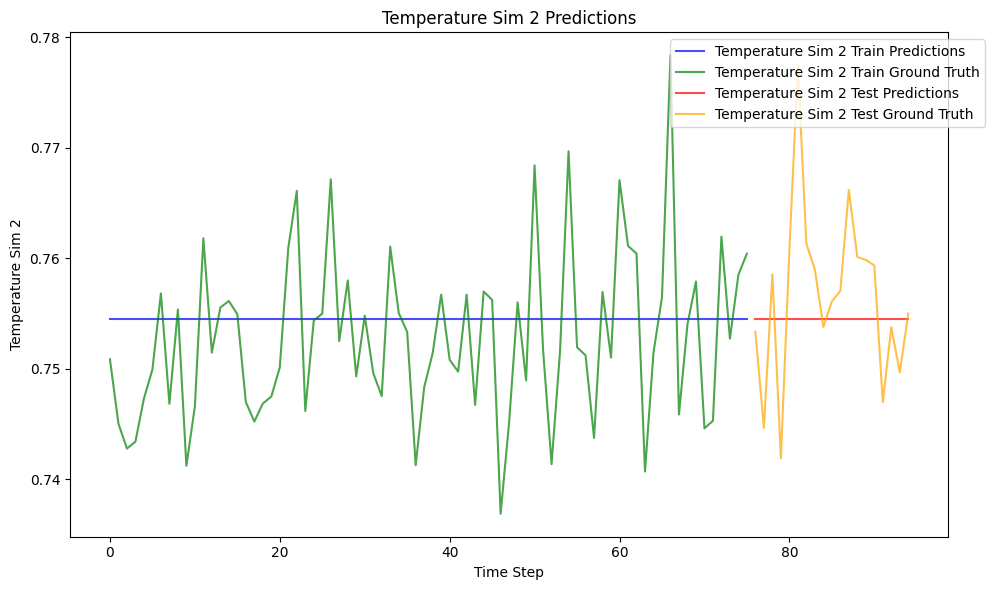

In [19]:
train_pred = model(X_train.to(training_config.device)).cpu().detach().numpy()
test_pred = model(X_test.to(training_config.device)).cpu().detach().numpy()

# Transform the predictions back to the original
train_pred, test_pred = scaler.inverse_transform(train_pred), scaler.inverse_transform(test_pred)
 
# Plot the optimised predictions of the model
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Can also use a second simulation, a Photoproduction Bioprocess Reactor.

This has state variables:
$C_x$ , biomass concentration in g/L

$C_N$ , nitrate concentration in mg/L

$C_{qc}$ , phycocyanin concentration in mg/L

The control variables are:
$I$, light intensity in $\mu  mol  m^{-2}  s^{-1}$

$F_N$, nitrate flow rate in $ mg. L^{-1} h{-1} $

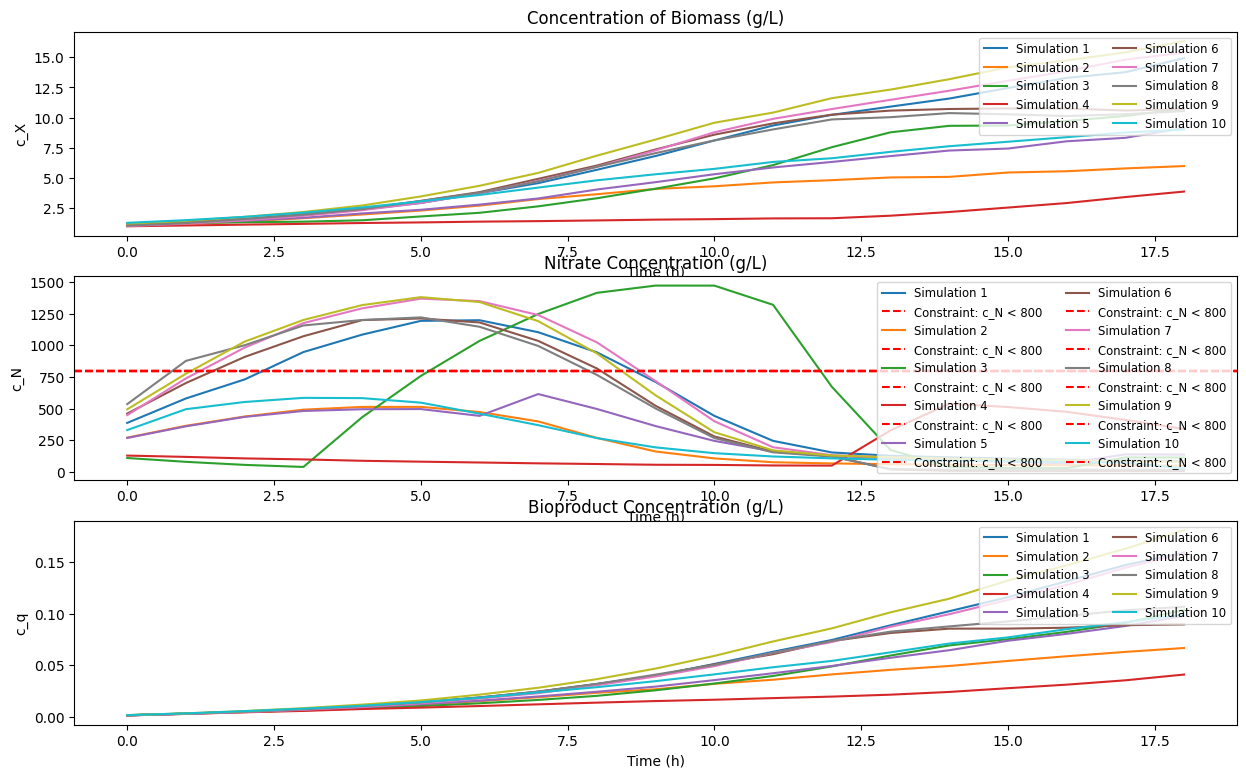

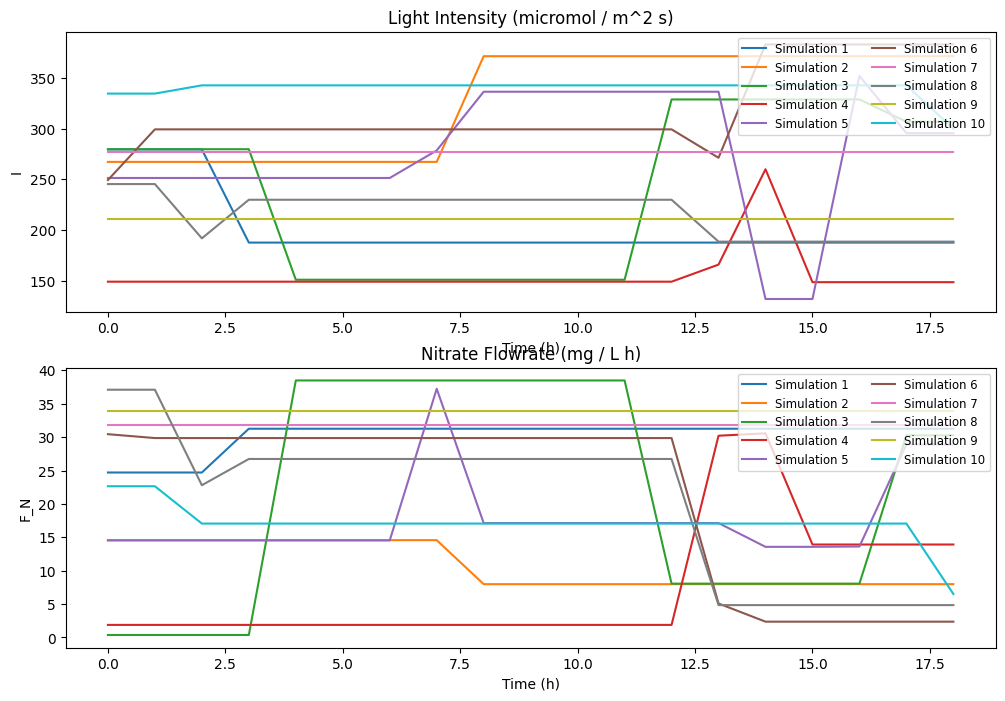

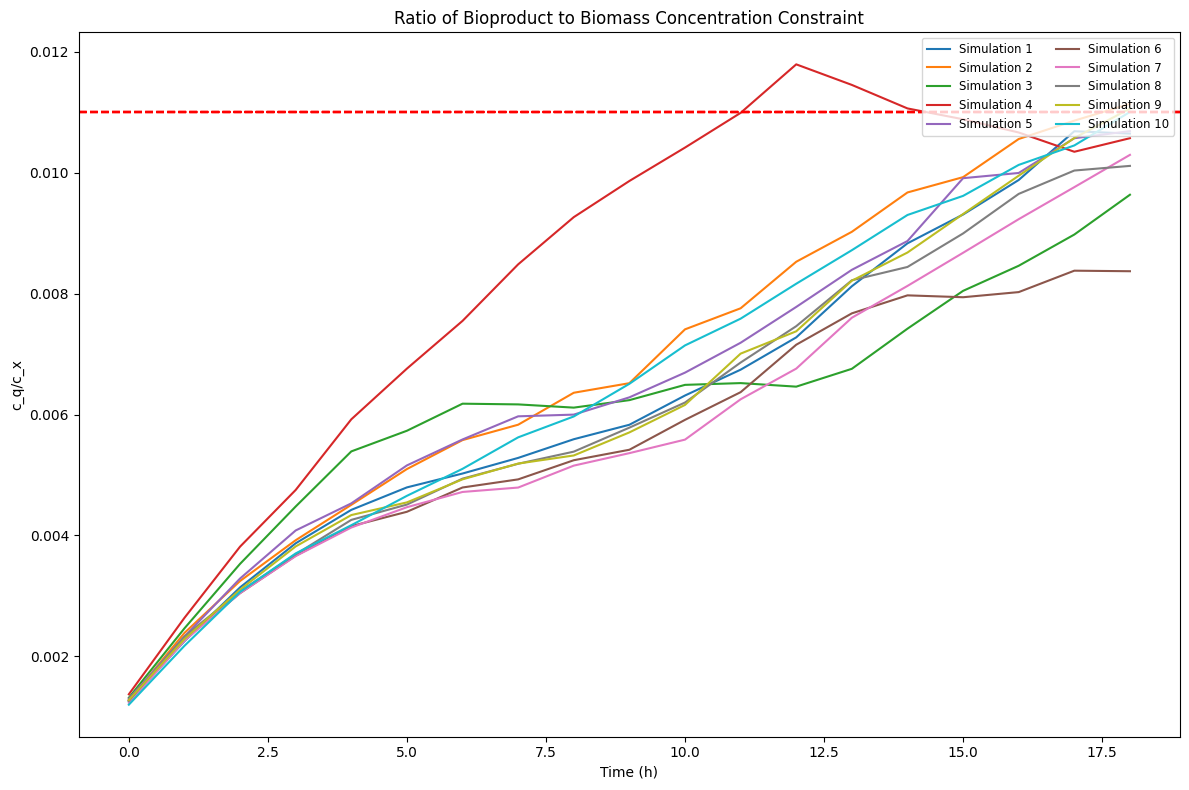

In [51]:
Bioprocess_Config = SimulationConfig(n_simulations=10, T = 20, tsim = 240) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = BioProcessSimulator(Bioprocess_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

In [52]:
converter = BioprocessConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Epoch [10/50], Train Loss: 0.1044, Test Loss: 0.2414, Avg Loss: 0.1729
Epoch [20/50], Train Loss: 0.0731, Test Loss: 0.1903, Avg Loss: 0.1317
Epoch [30/50], Train Loss: 0.0666, Test Loss: 0.1519, Avg Loss: 0.1092
Epoch [40/50], Train Loss: 0.0647, Test Loss: 0.1324, Avg Loss: 0.0986
Epoch [50/50], Train Loss: 0.0462, Test Loss: 0.0688, Avg Loss: 0.0575


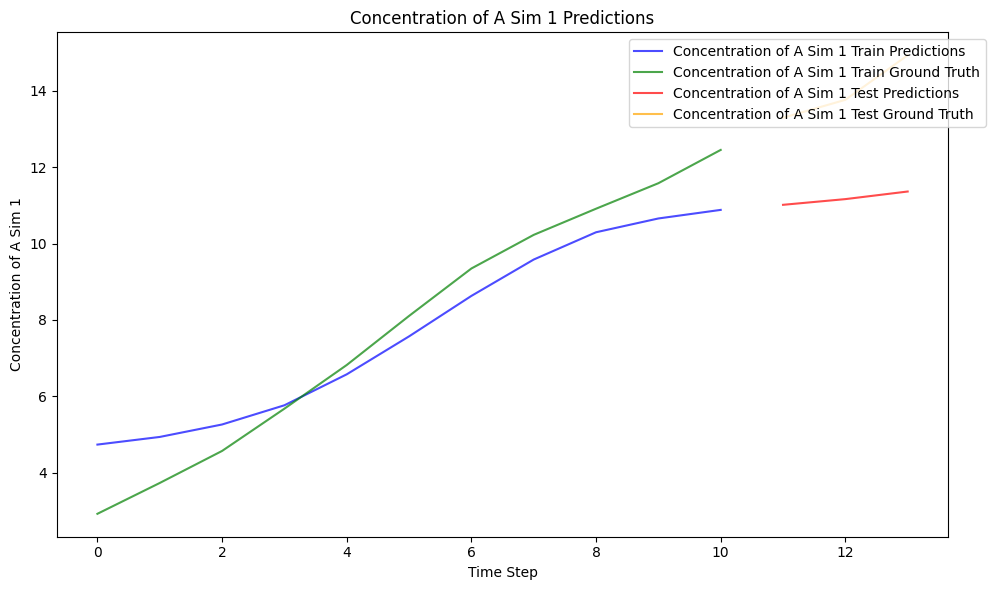

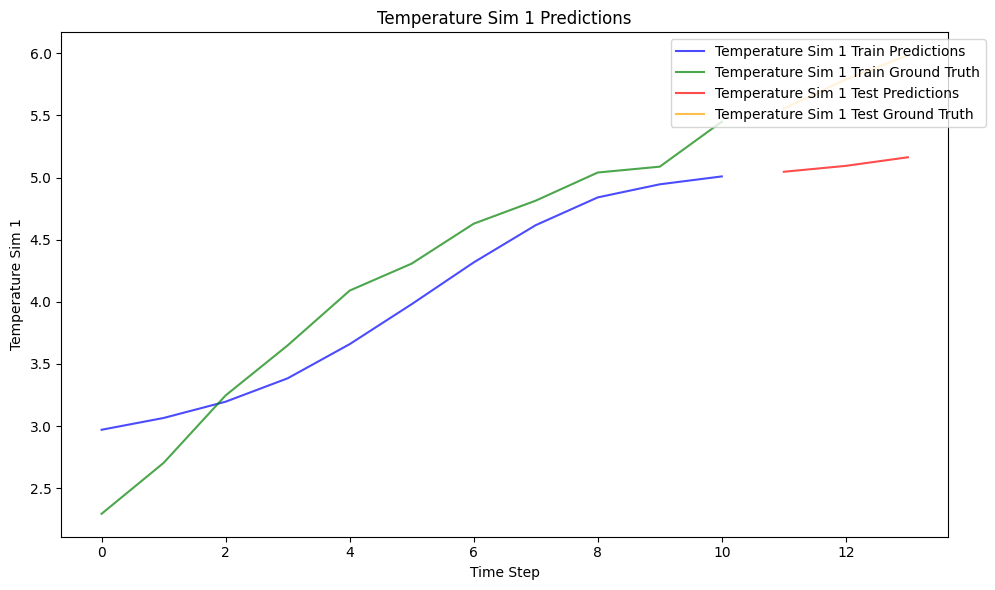

In [53]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

quantiles = [0.25, 0.5, 0.75]

model = StandardLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)

### Quantifying Uncertainty in the Model Output

#### Monte Carlo Dropout
   - This is essentially a Bayesian Approximation, as this involves sampling with replacement and randomly setting the weights of the output of the model to 0
   - This is applied post training, and accounts for the aleatoric uncertainty of the model

In [54]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

model = MC_LSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0931, Test Loss: 0.2279, Avg Loss: 0.1605
Epoch [20/50], Train Loss: 0.0784, Test Loss: 0.1978, Avg Loss: 0.1381
Epoch [30/50], Train Loss: 0.0738, Test Loss: 0.1765, Avg Loss: 0.1251
Epoch [40/50], Train Loss: 0.0798, Test Loss: 0.1549, Avg Loss: 0.1173
Epoch [50/50], Train Loss: 0.0679, Test Loss: 0.1126, Avg Loss: 0.0903


In [55]:
# Initialise the Monte Carlo Predictor
mc_predictor = MC_Prediction(model, LSTM_Config, num_samples = 1000)
# Pass the test data through the model, with a Monte Carlo sample size of 100
mean_train_pred, var_train_pred = mc_predictor.predict(X_train)
mean_test_pred, var_test_pred = mc_predictor.predict(X_test)

In [56]:
# Invert the training prediction
mean_train_pred, mean_test_pred = scaler.inverse_transform(mean_train_pred), scaler.inverse_transform(mean_test_pred)
var_train_pred, var_test_pred = scaler.inverse_transform(var_train_pred), scaler.inverse_transform(var_test_pred)

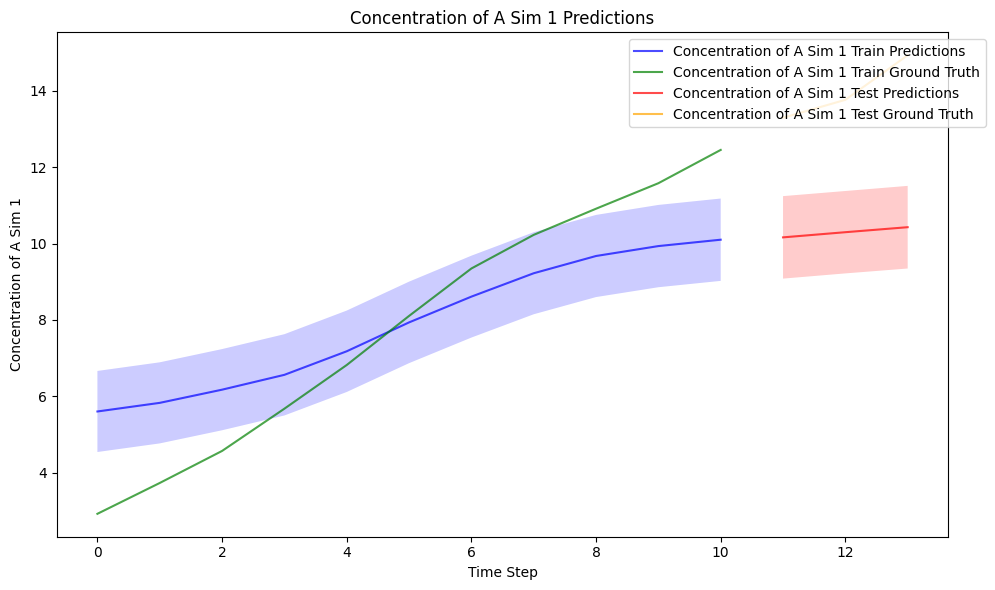

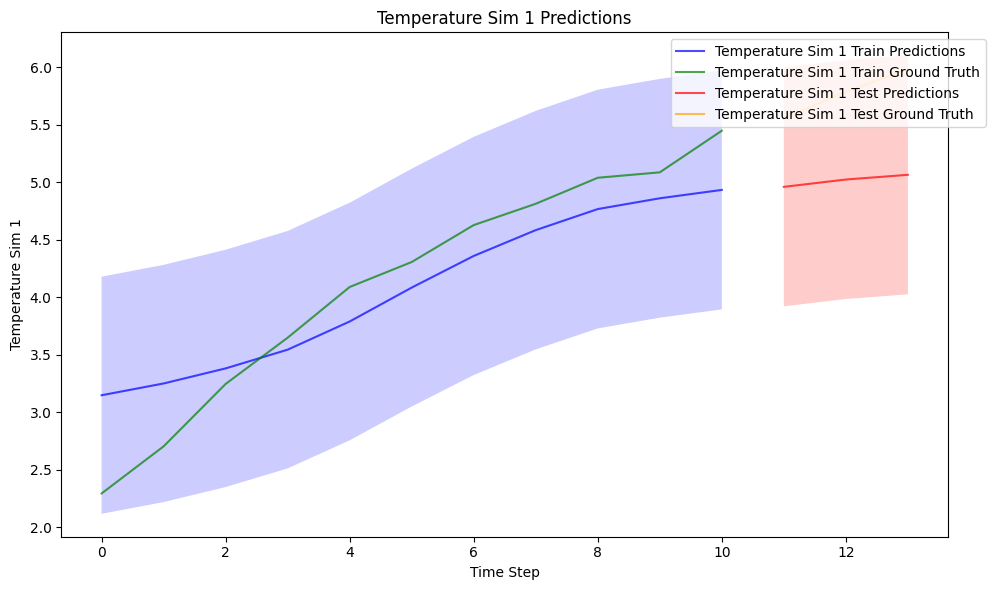

In [57]:
# Visualise the output
visualiser.plot_predictions(mean_train_pred, mean_test_pred, y_train, y_test, feature_names, num_simulations=1, train_var = var_train_pred, test_var = var_test_pred)

#### Negative Log Likelihood Loss Function
- This uses a second projection layer from the output of the network to predict the log variance of the prediction
- The output can be used to find uncertainty bounds
- The negative log likelihood assumes the output variables are normally distributed

In [58]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

model = NLL_LSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.GaussianNLLLoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: -0.0906, Test Loss: -0.0099, Avg Loss: -0.0503
Epoch [20/50], Train Loss: -0.8284, Test Loss: 0.4349, Avg Loss: -0.1968
Epoch [30/50], Train Loss: -1.2167, Test Loss: 0.3035, Avg Loss: -0.4566
Epoch [40/50], Train Loss: -1.7238, Test Loss: 1.9186, Avg Loss: 0.0974
Epoch [50/50], Train Loss: -2.1081, Test Loss: 4.8656, Avg Loss: 1.3787


In [59]:
# The NLL LSTM model outputs the mean and variance of the prediction
model.eval()
with torch.no_grad():
    train_pred, train_var = model(X_train.to(training_config.device))
    test_pred, test_var = model(X_test.to(training_config.device))
    
# Invert the predictions    
train_pred, test_pred = scaler.inverse_transform(train_pred.cpu().numpy()), scaler.inverse_transform(test_pred.cpu().numpy())
train_var, test_var = scaler.inverse_transform(train_var.cpu().numpy()), scaler.inverse_transform(test_var.cpu().numpy())

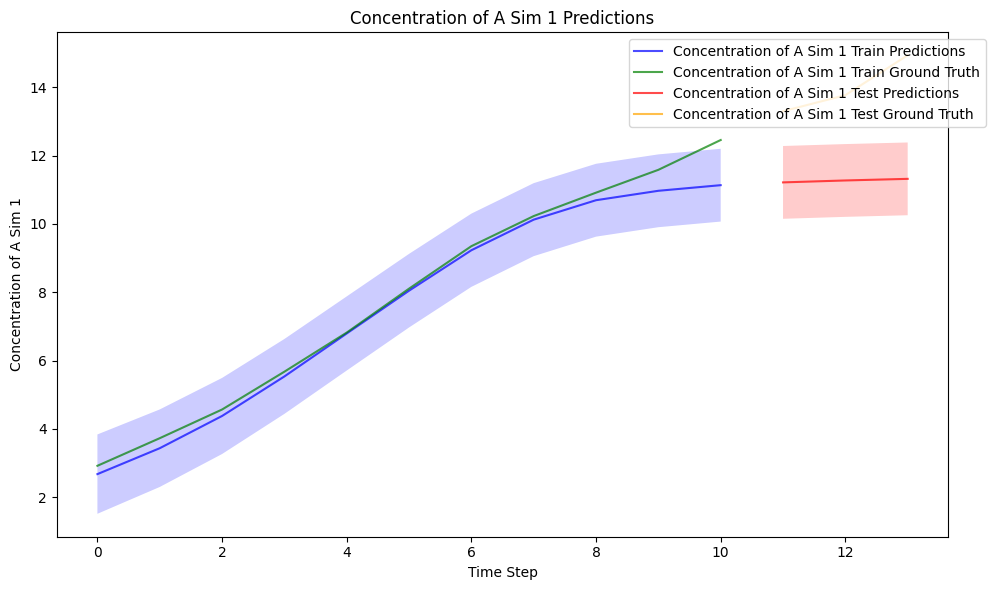

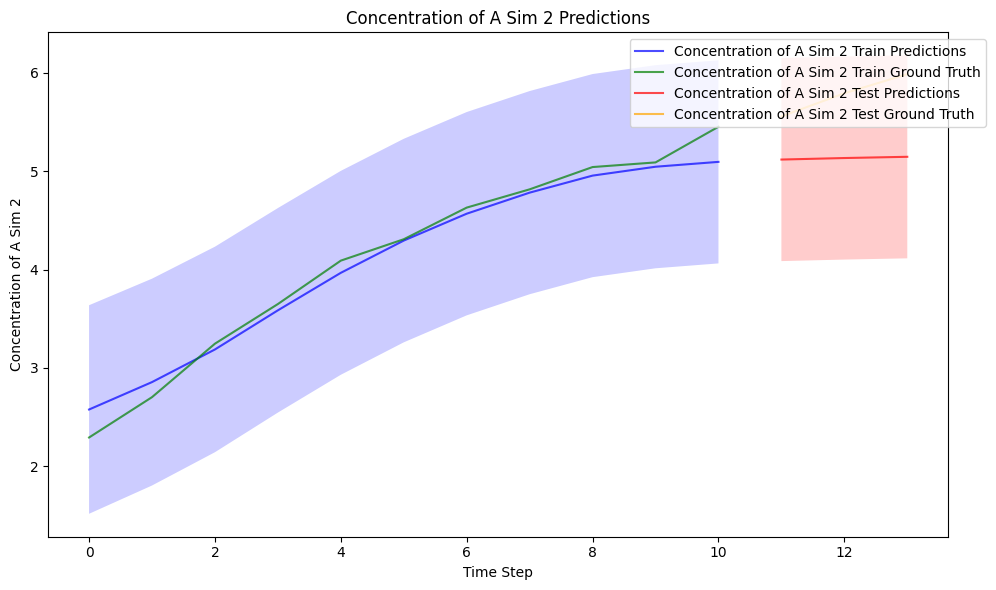

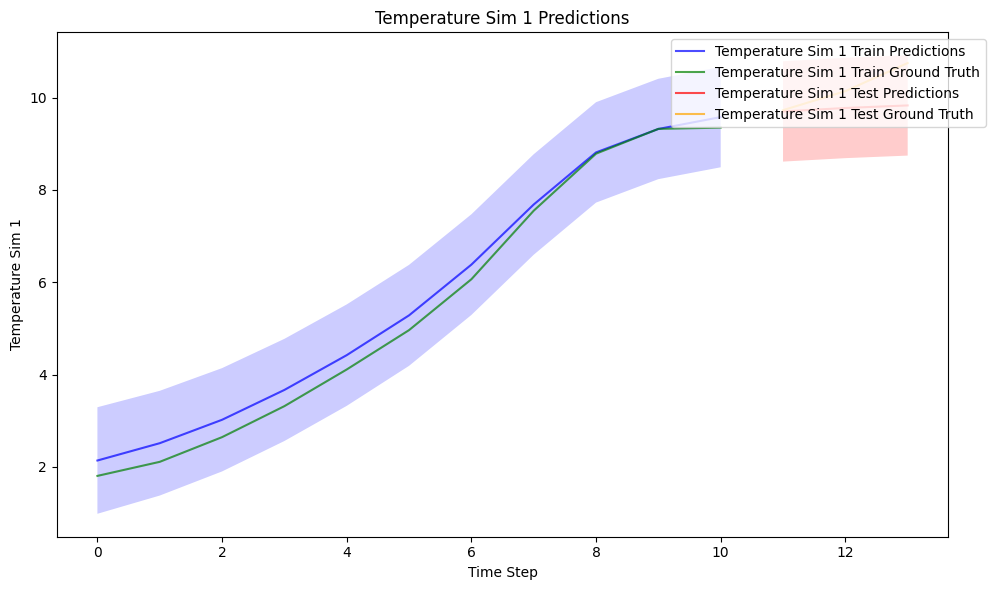

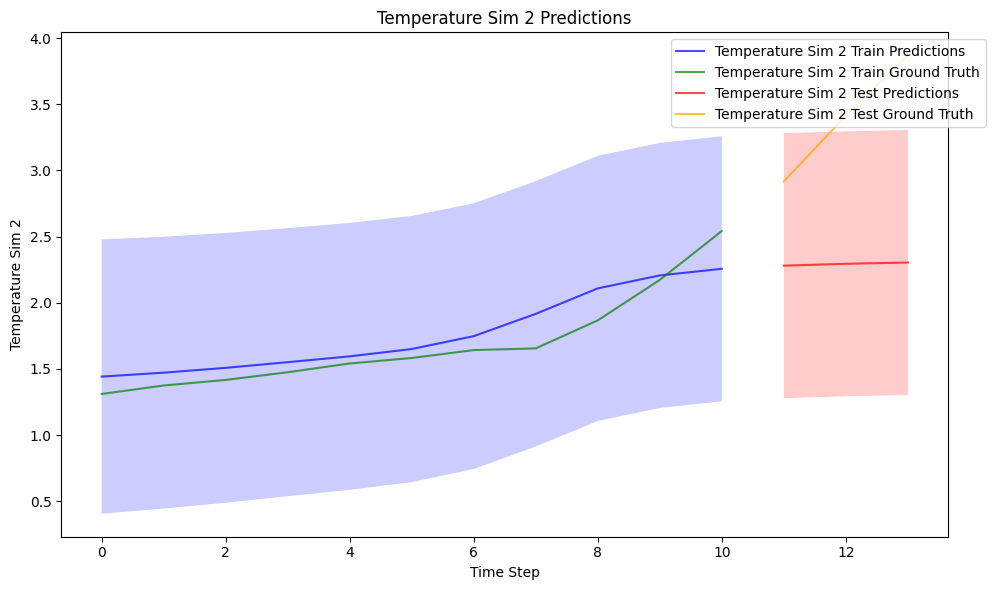

In [60]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2, train_var = train_var, test_var = test_var)

#### Quantile Regression
- Quantile Regression uses a pinball loss function to account for the 'quantile' the each prediction should lie above
- The median quantile reverts back to the MSE Loss Function
- Distribution free method

In [63]:
LSTM_Config = LSTMConfig(
    hidden_dim = 64,
    num_layers=2,
    dropout = 0.2,
    bidirectional=False,
)

# Train the model on the 25th, 50th and 75th quantiles
quantiles = [0.25, 0.5, 0.75]

model = QuantileLSTM(
    config = LSTM_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
    quantiles = quantiles
)

# Train the model
criterion = QuantileLoss(quantiles)
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.1826, Test Loss: 0.2916, Avg Loss: 0.2371
Epoch [20/50], Train Loss: 0.1228, Test Loss: 0.2203, Avg Loss: 0.1715
Epoch [30/50], Train Loss: 0.0946, Test Loss: 0.1743, Avg Loss: 0.1345
Epoch [40/50], Train Loss: 0.0826, Test Loss: 0.1440, Avg Loss: 0.1133
Epoch [50/50], Train Loss: 0.0758, Test Loss: 0.1171, Avg Loss: 0.0964


In [64]:
# Get the output of the model

model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Invert the output of the model
inverse_transformer = QuantileTransform(quantiles, scaler)
train_pred = inverse_transformer.inverse_transform(train_pred)
test_pred = inverse_transformer.inverse_transform(test_pred)

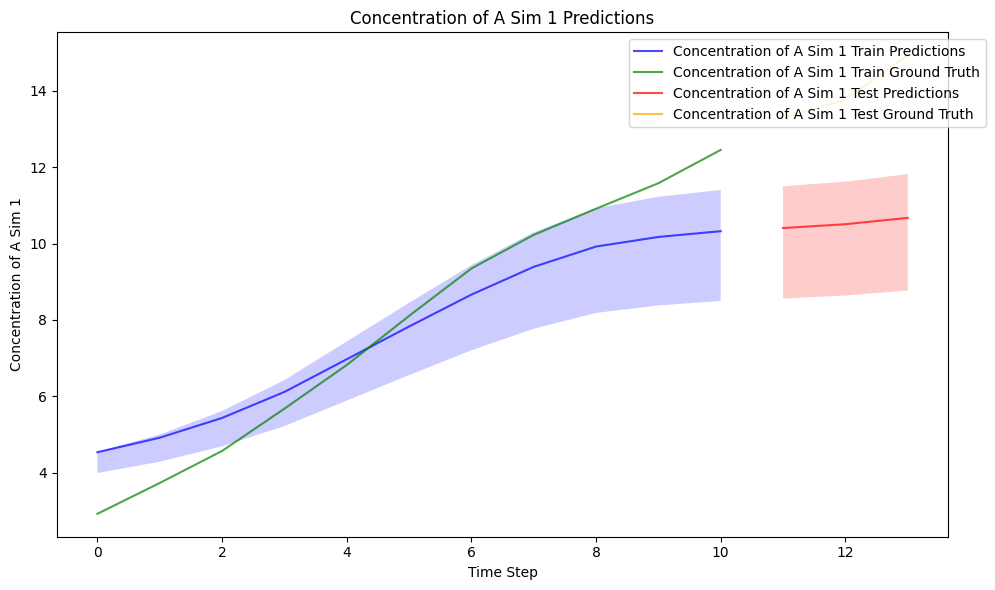

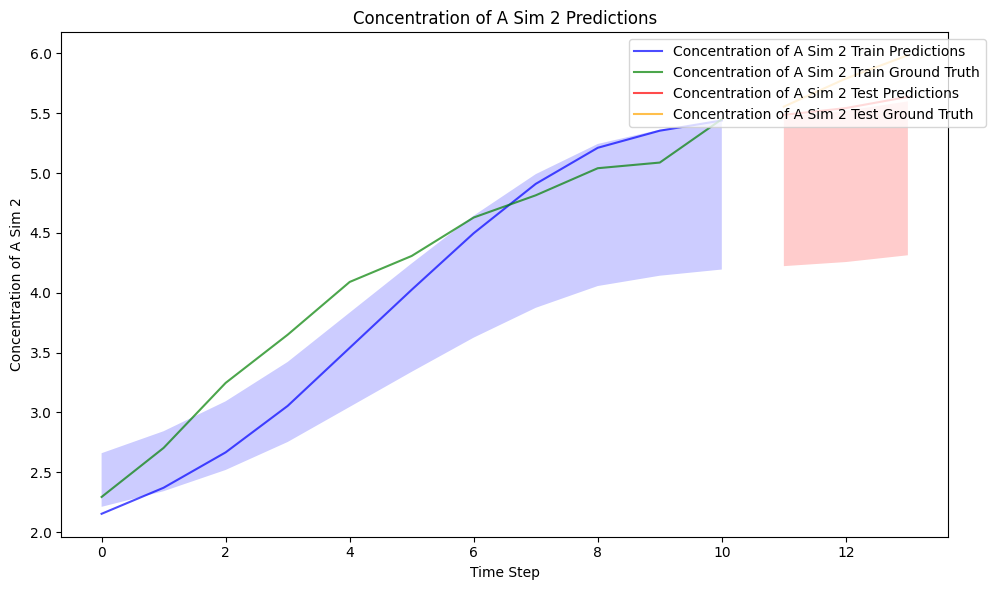

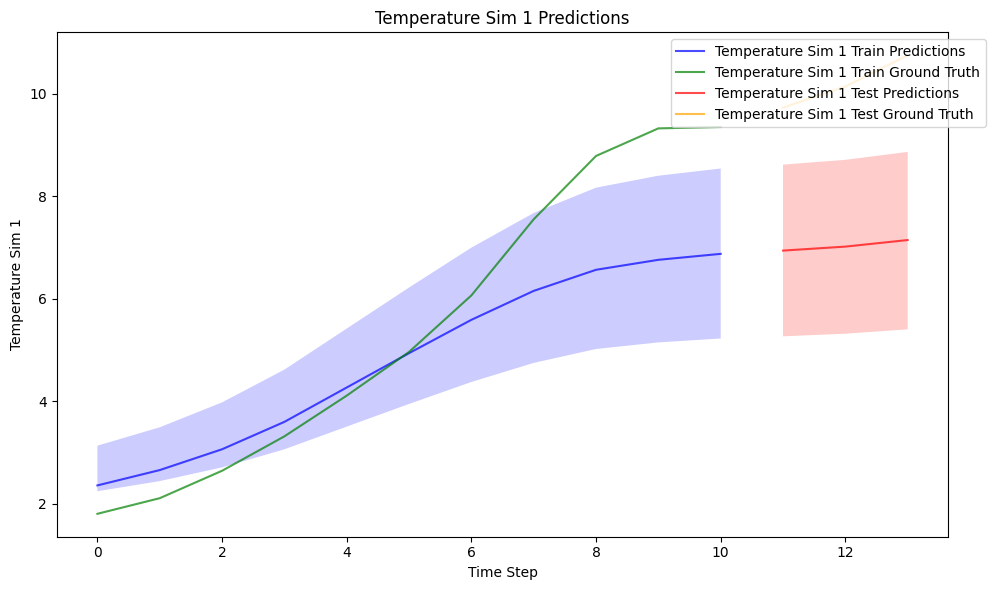

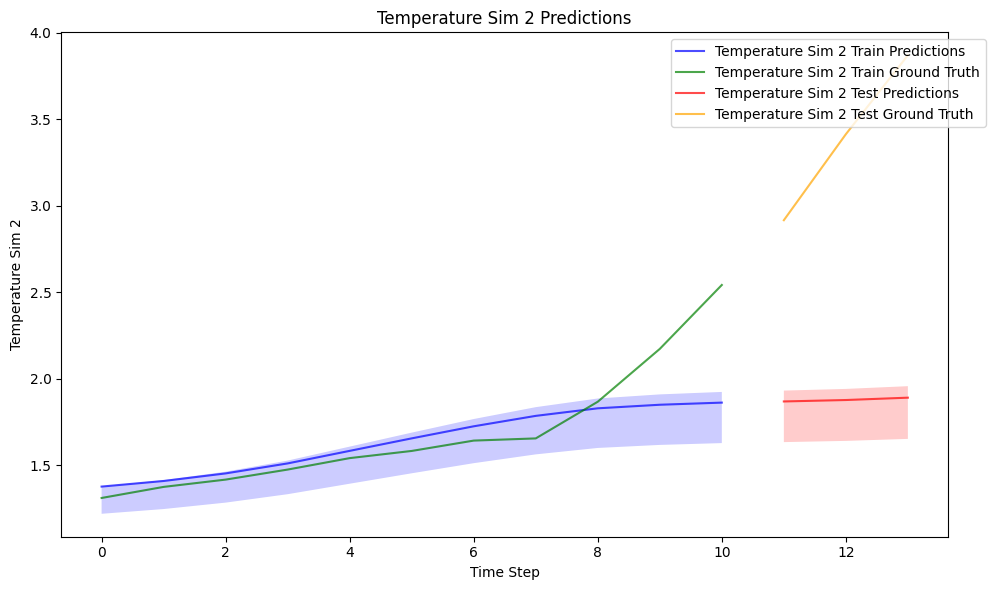

In [68]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Quantile regression offers no guarantees that a certain quantile will contain a certain amount of the data-points, hence is tough to provide an exact confidence level.
Conformal prediction uses the test set to calculate the residuals, assign a score and then after sorting the residuals, can calibrate a distribution free confidence bound.

[[1.32435054e+00 1.43048403e-01 1.11439319e+00 5.27634554e-01
  5.44112084e-01 2.69837668e-01 1.16866159e+00 2.39682580e-01
  1.10838332e+00 4.98558359e-01 7.19282094e+01 1.67155624e+01
  2.75387655e+02 1.62915255e+02 4.83394592e+01 7.69805311e+01
  8.68034600e+01 7.74778325e+01 6.73619362e+01 2.27289349e+01
  2.61427593e-02 6.55329737e-03 1.48059596e-02 3.16934226e-03
  1.38745979e-02 7.39576258e-03 2.36269235e-02 9.84734160e-03
  2.70695073e-02 1.24019947e-02]
 [1.50634087e+00 2.36134819e-01 1.27969793e+00 7.71823950e-01
  6.52771665e-01 3.20142431e-01 1.58756872e+00 2.50947618e-01
  1.37456776e+00 6.59509976e-01 7.61688732e+01 1.78787015e+01
  2.35536942e+02 1.30239104e+02 2.64067004e+01 7.73801383e+01
  8.94743929e+01 7.80396030e+01 7.17724963e+01 2.55288294e+01
  3.36064770e-02 8.40641601e-03 1.88719669e-02 5.13683293e-03
  1.74216416e-02 8.24429337e-03 3.15260698e-02 1.21410531e-02
  3.46482493e-02 1.54570453e-02]
 [2.00228469e+00 2.93420708e-01 1.51717969e+00 9.92775646e-01
  1.

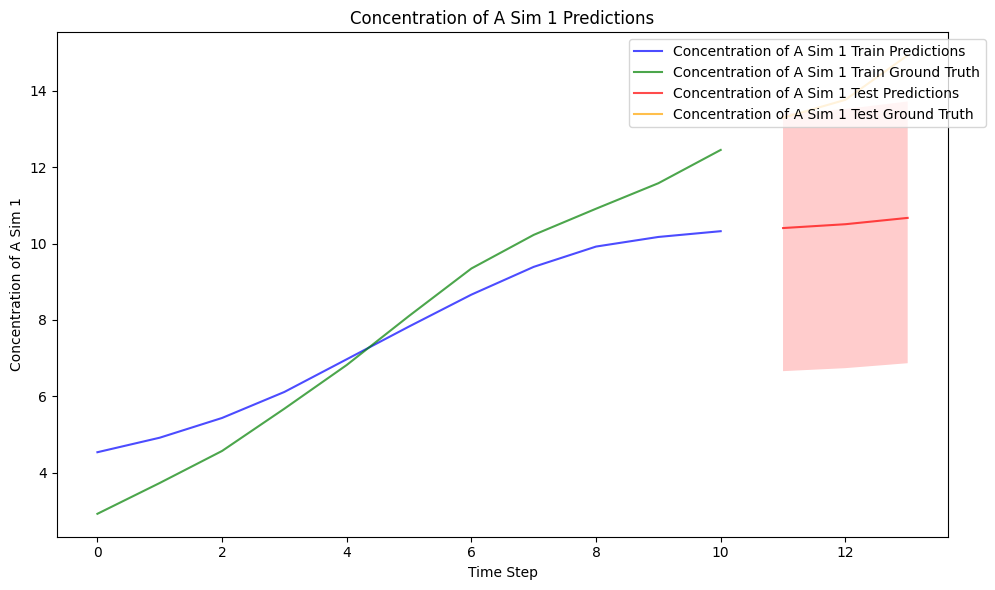

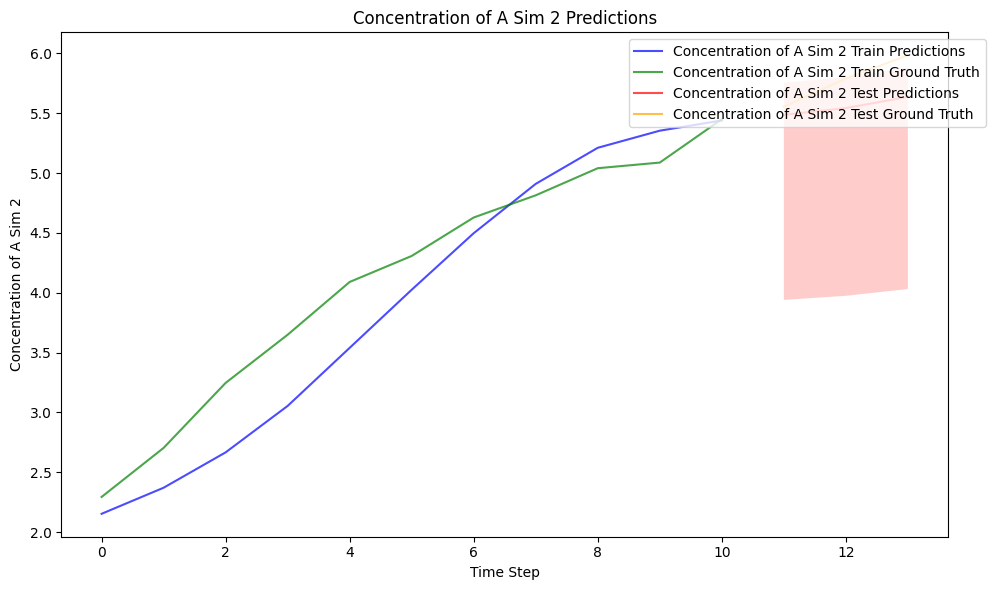

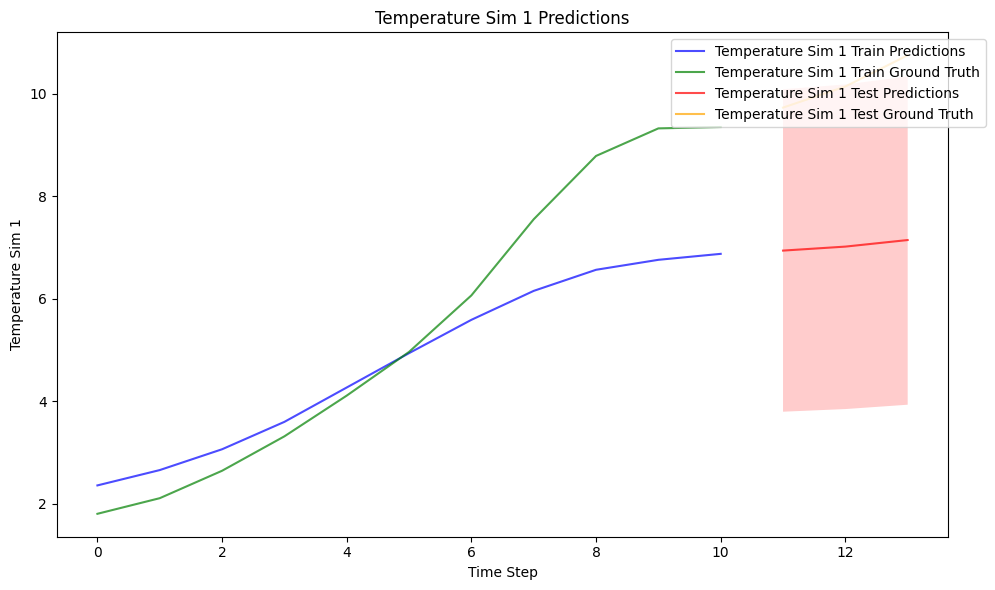

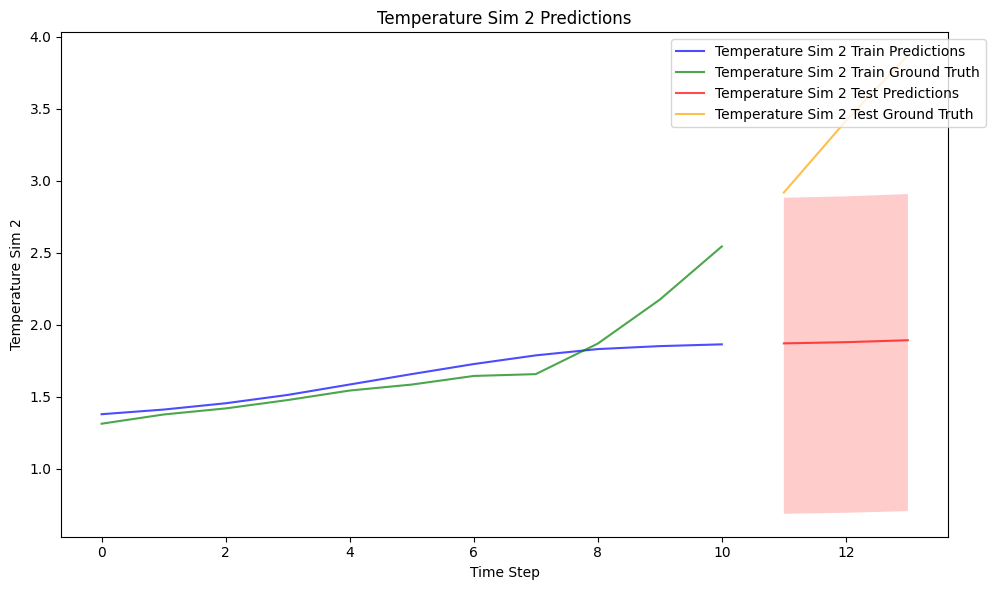

In [74]:
conformal = ConformalQuantile(model, inverse_transformer, alpha = 0.10) # Alpha is the parameter to bound the confidence interval - e.g. 0.1 = 90% confidence
conformal.fit_calibrate(X_test, y_test, method='absolute')
results = conformal.predict(X_test, y_test, method = 'absolute') # Calculates the absolute residuals 

# Results is a dictionary containing the 90% confidence bounds, and also the equivalent quantile corresponding to the desired confidence level
# e.g. the 90% confidence could be found between the 25th and 75th quantile

visualiser.plot_conformal(train_pred[0.5], test_pred[0.5], y_train, y_test, results, feature_names, num_simulations=2)